In [1]:
import random
from collections import deque
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter

## Adaptive Random sampling

Compute the single-source dependency scores $δ_s(v)$ for all vertices v in G using the unweighted version of Brandes' algorithm.

In [2]:
def brandes_single_source_dependencies_unweighted(G, s):
    S = []
    P = {v: [] for v in G}
    sigma = dict.fromkeys(G, 0.0)
    dist  = dict.fromkeys(G, -1)

    sigma[s] = 1.0
    dist[s] = 0

    from collections import deque
    Q = deque([s])

    while Q:
        v = Q.popleft()
        S.append(v)
        for w in G[v]:
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                P[w].append(v)

    delta = dict.fromkeys(G, 0.0)
    while S:
        w = S.pop()
        for v in P[w]:
            if sigma[w] != 0:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])

    return delta

In [3]:
def approx_bc_algorithm1_random(G, c=5.0, cutoff_factor=20, seed=0):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    max_bfs = max(1, n // cutoff_factor)
    print(f"[approx] adaptive + cutoff: max {max_bfs} BFS runs (n/{cutoff_factor}), c={c}")

    S = {v: 0.0 for v in nodes}      
    k = {v: 0   for v in nodes}    
    done = {v: False for v in nodes} 
    remaining = n                 

    bfs_used = 0
    t0 = perf_counter()

    while bfs_used < max_bfs and remaining > 0:
        s = rng.choice(nodes)
        delta = brandes_single_source_dependencies_unweighted(G, s)
        bfs_used += 1

        for v in nodes:
            if done[v] or v == s:
                continue
            S[v] += delta[v]
            k[v] += 1
            if S[v] >= c * n:
                done[v] = True
                remaining -= 1

        if bfs_used % 10 == 0 or bfs_used == max_bfs:
            print(f"[approx] BFS {bfs_used}/{max_bfs}, remaining not-done vertices: {remaining}")

    t1 = perf_counter()
    print(f"[approx] finished in {t1 - t0:.2f}s, BFS_used={bfs_used}")

    bc_hat = {
        v: (n * S[v] / k[v]) if k[v] > 0 else 0.0
        for v in nodes
    }

    if not G.is_directed():
        for v in bc_hat:
            bc_hat[v] /= 2.0
            
    return bc_hat, k, bfs_used

In [4]:
def smooth_series(y, window=51):
    w = max(3, int(window))
    if w % 2 == 0:
        w += 1
    if w > len(y):
        w = len(y) if len(y) % 2 == 1 else len(y) - 1
        if w < 3:
            return np.array(y, dtype=float)
    kernel = np.ones(w) / w
    ypad = np.pad(y, (w // 2, w // 2), mode='edge')
    return np.convolve(ypad, kernel, mode='valid')

## Degree-based sampling

In [7]:
def approx_bc_algorithm1_degree_based(G, c=5.0, cutoff_factor=20, alpha=1.0, seed=0):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    # compute degree-based sampling probabilities
    degs = np.array([G.degree(v) for v in nodes], dtype=float)
    if alpha == 0:
        weights = np.ones(n, dtype=float)
    else:
        weights = np.power(degs, alpha)
        
    if np.all(weights == 0):
        probs = np.ones(n, dtype=float) / n
    else:
        probs = weights / weights.sum() # Normalize so sum is 1
        
    cum_probs = np.cumsum(probs)

    # For fast probability lookup, create a mapping (or access directly via index)
    # Since nodes is a list, for efficiency, we assume index correspondence
    
    def sample_source_and_prob():
        x = rng.random()
        idx = np.searchsorted(cum_probs, x, side="left")
        if idx >= n:
            idx = n - 1
        return nodes[idx], probs[idx]

    max_bfs = max(1, n // cutoff_factor)
    print(f"[approx-alpha-degree] max {max_bfs} BFS runs, c={c}, alpha={alpha}")

    S = {v: 0.0 for v in nodes}
    k = {v: 0   for v in nodes}
    done = {v: False for v in nodes}
    remaining = n
    bfs_used = 0
    t0 = perf_counter()

    while bfs_used < max_bfs and remaining > 0:
        # sample source according to degree-based probabilities
        s, p_s = sample_source_and_prob() 

        delta = brandes_single_source_dependencies_unweighted(G, s)
        bfs_used += 1

        # sample source according to degree-based probabilities
        # Principle: Uniform probability is 1/n, current probability is p_s. Scale factor is (1/n) / p_s
        scale_factor = 1.0 / (n * p_s) if p_s > 0 else 0

        for v in nodes:
            if done[v] or v == s:
                continue
            
            S[v] += delta[v] * scale_factor 
            k[v] += 1
            
            if S[v] >= c * n: 
                done[v] = True
                remaining -= 1

        if bfs_used % 10 == 0 or bfs_used == max_bfs:
             print(f"[approx-alpha-degree] BFS {bfs_used}/{max_bfs}, remaining={remaining}")

    t1 = perf_counter()
    print(f"[approx-alpha-degree] finished in {t1 - t0:.2f}s")

    bc_hat = {
        v: (n * S[v] / k[v]) if k[v] > 0 else 0.0
        for v in nodes
    }

    if not G.is_directed():
        for v in bc_hat:
            bc_hat[v] /= 2.0
            
    return bc_hat, k, bfs_used

Function to Plot Figure 1

In [8]:
def plot_fig1(exact_bc, approx_bc_rand, approx_bc_deg, title_suffix="CA-AstroPh"):

    # 1. rank vertices by exact BC
    nodes_sorted = sorted(exact_bc.keys(), key=lambda v: exact_bc[v])
    x = np.arange(len(nodes_sorted))

    # 2. get y values
    y_exact  = np.array([exact_bc[v]       for v in nodes_sorted])
    y_rand   = np.array([approx_bc_rand[v] for v in nodes_sorted])
    y_deg    = np.array([approx_bc_deg[v]  for v in nodes_sorted])

    # 3. smooth the two approx series to reduce jaggedness
    y_rand_smooth = smooth_series(y_rand, window=max(31, len(y_rand)//50))
    y_deg_smooth  = smooth_series(y_deg,  window=max(31, len(y_deg)//50))

    # 4. plot
    plt.figure(figsize=(7, 4))

    # exact uses scatter
    plt.scatter(x, y_exact, s=5, alpha=0.6, label="Exact (Brandes)")

    # random & degree-based use smoothed lines
    plt.plot(x, y_rand_smooth, "r--", lw=1.8, label="Random adaptive (c=5)")
    plt.plot(x, y_deg_smooth,  "g-.", lw=1.8, label="Degree-based adaptive (c=5)")

    plt.yscale("log")  # y-axis log scale
    plt.xlabel("Vertices (sorted by exact betweenness)")
    plt.ylabel("Betweenness centrality")
    plt.title(f"{title_suffix} – Betweenness distribution")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Function to plot fig 2

In [37]:
def plot_bc_error_two_methods(
    exact_bc,
    approx_bc_deg,
    approx_bc_rand,
    top_k= 30,  
    label_deg="Degree-based sampling",
    label_rand="Adaptive random sampling",
    color_deg="green",
    color_rand="red",
    title=None,
):
    
    # top-k nodes by exact BC
    top_nodes = sorted(exact_bc, key=exact_bc.get, reverse=True)[:top_k]

    err_deg = []
    err_rand = []

    for rank, v in enumerate(top_nodes, start=1):
        exact_val = exact_bc[v]
        rand_val = approx_bc_rand.get(v, 0.0)
        deg_val  = approx_bc_deg.get(v, 0.0)

        if exact_val == 0:
            e_rand = 0.0
            e_deg  = 0.0
        else:
            e_rand = abs(rand_val - exact_val) / exact_val * 100
            e_deg  = abs(deg_val  - exact_val) / exact_val * 100

        err_rand.append(e_rand)
        err_deg.append(e_deg)

    #  Plot Figure 2
    x = np.arange(1, top_k + 1)

    # expand figure width to reduce crowding
    plt.figure(figsize=(10, 5)) 

    # Plot lines, slightly reduce marker size (ms=4) to fit dense points
    plt.plot(x, err_deg, marker="o", ms=4, label=label_deg, color=color_deg, linewidth=1.5)
    plt.plot(x, err_rand, marker="o", ms=4, label=label_rand, color=color_rand, linewidth=1.5)

    plt.xlabel("High-centrality vertices (ranked by exact BC)")
    plt.ylabel("Approximate centrality error (%)")

    # === Key modification: optimize X-axis ticks ===
    # If top_k > 30, don't show every tick, show one every 5 or 10
    if top_k > 30:
        step = 5  # Show a tick every 5
        # np.arange(1, top_k + 1, step) generates [1, 6, 11, ...]
        ticks = np.arange(0, top_k + 1, step)
        ticks[0] = 1 # Replace 0 with 1, or start from 5
        # More elegant approach: show 1, 5, 10, 15...
        ticks = [1] + list(range(5, top_k + 1, 5))
        plt.xticks(ticks)
    else:
        plt.xticks(x) # Show all ticks when the number is small

    ymax = max(err_deg + err_rand)
    plt.ylim(0, ymax * 1.15)

    if title:
        plt.title(title)

    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

Function to plot fig 3, the percentage of BFS/SSSP computations required for ap-
proximating the centrality scores

In [41]:
def plot_bfs_percentages(
    G,
    exact_bc,
    k_used_deg,
    k_used_rand,
    top_k=30,
    label_deg="Degree-based sampling",
    label_rand="Adaptive random sampling",
    color_deg="green",
    color_rand="red",
    title=None
):
    """
    Plot sampling percentage for top-k high-centrality nodes
    based on exact betweenness centrality ranking.
    """

    n = G.number_of_nodes()

    # Get top-K nodes by exact BC 
    top_nodes = sorted(exact_bc, key=exact_bc.get, reverse=True)[:top_k]

    # Compute percentages for each algorithm
    deg_pct = [ 100.0 * k_used_deg[v] / n for v in top_nodes]
    rand_pct = [ 100.0 * k_used_rand[v] / n for v in top_nodes]

    x = np.arange(1, top_k + 1)

    # Adjust figure size to reduce crowding
    plt.figure(figsize=(10, 5))

    
    plt.plot(x, deg_pct, marker="o", ms=4, color=color_deg, label=label_deg)
    plt.plot(x, rand_pct, marker="o", ms=4, color=color_rand, label=label_rand)

    plt.xlabel("High-centrality vertices (ranked by exact BC)")
    plt.ylabel("Percentage of source vertices considered (%)")

    if top_k > 30:
        ticks = [1] + list(range(5, top_k + 1, 5))
        plt.xticks(ticks)
    else:
        plt.xticks(x)

    ymax = max(deg_pct + rand_pct)
    plt.ylim(0, ymax * 1.15)

    if title:
        plt.title(title)

    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

Function for loading graph

In [11]:
def load_graph(
    path,
    directed: bool,
    use_giant_component: bool = True,
):
    """
    Load a graph from an edgelist file.

    Parameters
    ----------
    path : str
        Path to the edgelist file.
    directed : bool
        True -> DiGraph, False -> Graph.
    use_giant_component : bool
        If True, keep only the largest (weakly) connected component.

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """

    GraphClass = nx.DiGraph if directed else nx.Graph

    # read graph from edgelist
    G = nx.read_edgelist(
        path,
        comments="#",
        create_using=GraphClass(),
        nodetype=int,
    )
    print(f"[load] full graph from {path}: n={G.number_of_nodes()}, m={G.number_of_edges()}")

    # keep only the giant component
    if use_giant_component:
        if directed:
            is_conn = nx.is_weakly_connected(G)
            if not is_conn:
                gcc_nodes = max(nx.weakly_connected_components(G), key=len)
                G = G.subgraph(gcc_nodes).copy()
                print(f"[load] use giant WCC: n={G.number_of_nodes()}, m={G.number_of_edges()}")
        else:
            is_conn = nx.is_connected(G)
            if not is_conn:
                gcc_nodes = max(nx.connected_components(G), key=len)
                G = G.subgraph(gcc_nodes).copy()
                print(f"[load] use giant CC: n={G.number_of_nodes()}, m={G.number_of_edges()}")


    return G

In [12]:
def load_csv_edge_list(path, directed=True):
    GraphClass = nx.DiGraph if directed else nx.Graph

    with open(path, "r") as f:
        header = next(f)  
        G = nx.read_edgelist(
            f,                
            delimiter=",",
            create_using=GraphClass(),
            nodetype=int,
            data=False,
        )

    print(f"Facebook CSV graph: n={G.number_of_nodes()}, m={G.number_of_edges()}")
    return G

Compute error for top k nodes

In [50]:
def compute_top_k_error(exact_bc, approx_bc, k=30):
    # rank nodes by exact BC from high to low
    top_k_nodes = sorted(exact_bc.keys(), key=lambda v: exact_bc[v], reverse=True)[:k]
    
    errors = []
    for v in top_k_nodes:
        exact_val = exact_bc[v]
        approx_val = approx_bc.get(v, 0.0) # in case v not in approx_bc
        
        # avoid division by zero
        if exact_val > 0:
            err = abs(approx_val - exact_val) / exact_val
            errors.append(err)
            
    if not errors:
        return 0.0
        
    return np.mean(errors) * 100  # return percentage

## Set parameters

In [107]:
c_val = 5
cutoff_factor = 20
top_k = 30
alpha = 1.0
seed = 42

## CA-AstroPh
undirected

In [13]:
G_ca = load_graph("../data/real-world-new/CA-AstroPh_undirected.txt",
                       directed=False, use_giant_component=True)
n_ca = G_ca.number_of_nodes()
print("CA-AstroPh:", n_ca, G_ca.number_of_edges())

[load] full graph from ../data/real-world-new/CA-AstroPh_undirected.txt: n=18772, m=198110
[load] use giant CC: n=17903, m=197031
CA-AstroPh: 17903 197031


In [ ]:
# Approximate: one run, c=5, cutoff n/20 
approx_ca, k_used_ca, bfs_used_ca = approx_bc_algorithm1_random(
    G_ca,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)
print(f"[CA-AstroPh approx] BFS used = {bfs_used_ca}, "
      f"avg samples per node = {np.mean(list(k_used_ca.values())):.2f}")

[approx] adaptive + cutoff: max 895 BFS runs (n/20), c=5
[approx] BFS 10/895, remaining not-done vertices: 17903
[approx] BFS 20/895, remaining not-done vertices: 17903
[approx] BFS 30/895, remaining not-done vertices: 17903
[approx] BFS 40/895, remaining not-done vertices: 17903
[approx] BFS 50/895, remaining not-done vertices: 17903
[approx] BFS 60/895, remaining not-done vertices: 17903
[approx] BFS 70/895, remaining not-done vertices: 17903
[approx] BFS 80/895, remaining not-done vertices: 17903
[approx] BFS 90/895, remaining not-done vertices: 17903
[approx] BFS 100/895, remaining not-done vertices: 17903
[approx] BFS 110/895, remaining not-done vertices: 17903
[approx] BFS 120/895, remaining not-done vertices: 17903
[approx] BFS 130/895, remaining not-done vertices: 17903
[approx] BFS 140/895, remaining not-done vertices: 17903
[approx] BFS 150/895, remaining not-done vertices: 17903
[approx] BFS 160/895, remaining not-done vertices: 17903
[approx] BFS 170/895, remaining not-done

degree-based sampling

In [ ]:
approx_ca_deg, k_used_ca_deg, bfs_used_ca_deg = approx_bc_algorithm1_degree_based(
    G_ca,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)
print(f"[CA-AstroPh approx DEGREE] BFS used = {bfs_used_ca_deg}, "
      f"avg samples per node = {np.mean(list(k_used_ca_deg.values())):.2f}")

[approx-alpha-degree] max 895 BFS runs, c=5, alpha=1.0
[approx-alpha-degree] BFS 10/895, remaining=17903
[approx-alpha-degree] BFS 20/895, remaining=17903
[approx-alpha-degree] BFS 30/895, remaining=17903
[approx-alpha-degree] BFS 40/895, remaining=17902
[approx-alpha-degree] BFS 50/895, remaining=17902
[approx-alpha-degree] BFS 60/895, remaining=17902
[approx-alpha-degree] BFS 70/895, remaining=17902
[approx-alpha-degree] BFS 80/895, remaining=17902
[approx-alpha-degree] BFS 90/895, remaining=17902
[approx-alpha-degree] BFS 100/895, remaining=17902
[approx-alpha-degree] BFS 110/895, remaining=17902
[approx-alpha-degree] BFS 120/895, remaining=17902
[approx-alpha-degree] BFS 130/895, remaining=17902
[approx-alpha-degree] BFS 140/895, remaining=17902
[approx-alpha-degree] BFS 150/895, remaining=17902
[approx-alpha-degree] BFS 160/895, remaining=17899
[approx-alpha-degree] BFS 170/895, remaining=17899
[approx-alpha-degree] BFS 180/895, remaining=17899
[approx-alpha-degree] BFS 190/895, r

Brandes Exact BC O(nm)

In [16]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_ca = nx.betweenness_centrality(G_ca, normalized=False)
t1 = perf_counter()
print(f"[CA-AstroPh exact] finished in {t1 - t0:.2f}s")


[CA-AstroPh exact] finished in 1154.25s


Fig 1 BC distribution

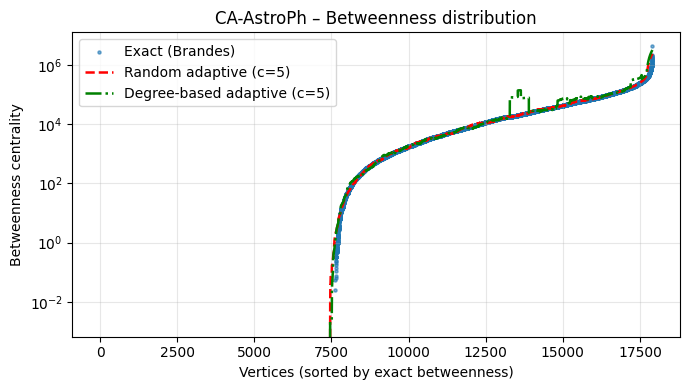

In [17]:
plot_fig1(
    exact_bc     = exact_ca,
    approx_bc_rand= approx_ca,        # random adaptive result
    approx_bc_deg = approx_ca_deg,    # degree-based adaptive result
    title_suffix  = "CA-AstroPh"
)

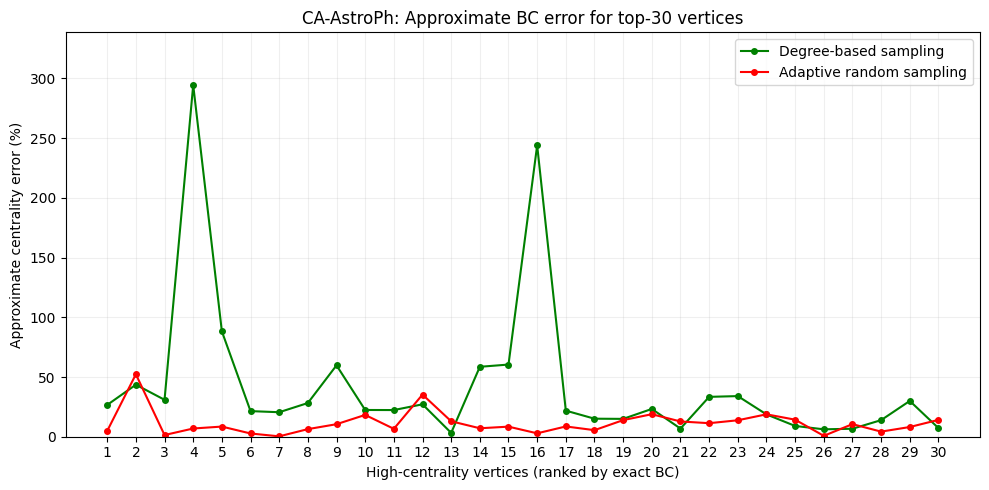

In [108]:
plot_bc_error_two_methods(
    exact_bc=exact_ca,
    approx_bc_deg=approx_ca_deg,
    approx_bc_rand=approx_ca,
    top_k= top_k,
    title=f"CA-AstroPh: Approximate BC error for top-{top_k} vertices"
)

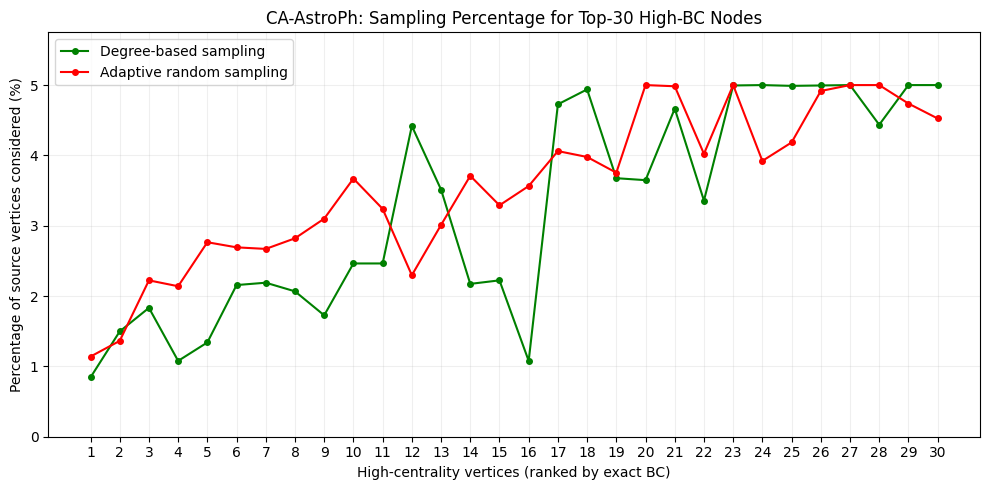

In [109]:
plot_bfs_percentages(
    G_ca,
    exact_ca,
    k_used_ca_deg,
    k_used_ca,
    top_k= top_k,
    title=f"CA-AstroPh: Sampling Percentage for Top-{top_k} High-BC Nodes"
)

Compute the average error on top-k nodes

In [110]:

avg_err_rand_topk = compute_top_k_error(exact_ca, approx_ca, k=top_k)
avg_err_deg_topk  = compute_top_k_error(exact_ca, approx_ca_deg, k=top_k)

print(f"Average Error (Top-{top_k} Nodes) - Random: {avg_err_rand_topk:.2f}%")
print(f"Average Error (Top-{top_k} Nodes) - Degree-based: {avg_err_deg_topk:.2f}%")

Average Error (Top-30 Nodes) - Random: 11.36%
Average Error (Top-30 Nodes) - Degree-based: 43.10%


P2P dataset
directed https://snap.stanford.edu/data/p2p-Gnutella31.html

In [22]:
p2p_path = "../data/real-world-new/p2p-Gnutella31_directed.txt"  
G_p2p = load_graph(p2p_path, directed=True, use_giant_component=True)
n_p2p = G_p2p.number_of_nodes()
print("P2P-Gnutella31:", n_p2p, G_p2p.number_of_edges())

[load] full graph from ../data/real-world-new/p2p-Gnutella31_directed.txt: n=62586, m=147892
[load] use giant WCC: n=62561, m=147878
P2P-Gnutella31: 62561 147878


In [ ]:
approx_p2p, k_used_p2p, bfs_used_p2p = approx_bc_algorithm1_random(
    G_p2p,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)

print(
    f"[P2P-Gnutella31 approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_p2p}, "
    f"avg samples per node = {np.mean(list(k_used_p2p.values())):.2f}"
)

[approx] adaptive + cutoff: max 3128 BFS runs (n/20), c=5.0
[approx] BFS 10/3128, remaining not-done vertices: 62561
[approx] BFS 20/3128, remaining not-done vertices: 62561
[approx] BFS 30/3128, remaining not-done vertices: 62561
[approx] BFS 40/3128, remaining not-done vertices: 62561
[approx] BFS 50/3128, remaining not-done vertices: 62561
[approx] BFS 60/3128, remaining not-done vertices: 62561
[approx] BFS 70/3128, remaining not-done vertices: 62561
[approx] BFS 80/3128, remaining not-done vertices: 62561
[approx] BFS 90/3128, remaining not-done vertices: 62561
[approx] BFS 100/3128, remaining not-done vertices: 62561
[approx] BFS 110/3128, remaining not-done vertices: 62561
[approx] BFS 120/3128, remaining not-done vertices: 62561
[approx] BFS 130/3128, remaining not-done vertices: 62561
[approx] BFS 140/3128, remaining not-done vertices: 62561
[approx] BFS 150/3128, remaining not-done vertices: 62561
[approx] BFS 160/3128, remaining not-done vertices: 62561
[approx] BFS 170/3128

In [ ]:
approx_p2p_deg, k_used_p2p_deg, bfs_used_p2p_deg = approx_bc_algorithm1_degree_based(
    G_p2p,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)

print(
    f"[P2P-Gnutella31 approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_p2p_deg}, "
    f"avg samples per node = {np.mean(list(k_used_p2p_deg.values())):.2f}"
)

[approx-alpha-degree] max 3128 BFS runs, c=5.0, alpha=1.0
[approx-alpha-degree] BFS 10/3128, remaining=62561
[approx-alpha-degree] BFS 20/3128, remaining=62561
[approx-alpha-degree] BFS 30/3128, remaining=62561
[approx-alpha-degree] BFS 40/3128, remaining=62561
[approx-alpha-degree] BFS 50/3128, remaining=62561
[approx-alpha-degree] BFS 60/3128, remaining=62561
[approx-alpha-degree] BFS 70/3128, remaining=62561
[approx-alpha-degree] BFS 80/3128, remaining=62561
[approx-alpha-degree] BFS 90/3128, remaining=62561
[approx-alpha-degree] BFS 100/3128, remaining=62561
[approx-alpha-degree] BFS 110/3128, remaining=62561
[approx-alpha-degree] BFS 120/3128, remaining=62561
[approx-alpha-degree] BFS 130/3128, remaining=62561
[approx-alpha-degree] BFS 140/3128, remaining=62561
[approx-alpha-degree] BFS 150/3128, remaining=62561
[approx-alpha-degree] BFS 160/3128, remaining=62561
[approx-alpha-degree] BFS 170/3128, remaining=62561
[approx-alpha-degree] BFS 180/3128, remaining=62561
[approx-alpha-d

In [44]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_p2p = nx.betweenness_centrality(G_p2p, normalized=False)
t1 = perf_counter()
print(f"[P2P-Gnutella31 exact] finished in {t1 - t0:.2f}s")

[P2P-Gnutella31 exact] finished in 2424.96s


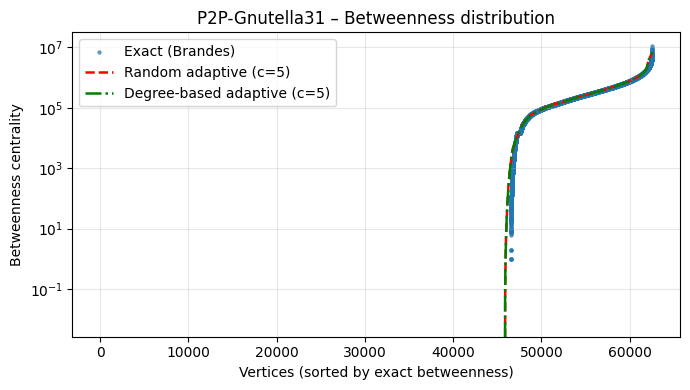

In [45]:
plot_fig1(
    exact_bc      = exact_p2p,
    approx_bc_rand= approx_p2p,        # random adaptive result
    approx_bc_deg = approx_p2p_deg,    # degree-based adaptive result
    title_suffix  = "P2P-Gnutella31"
)

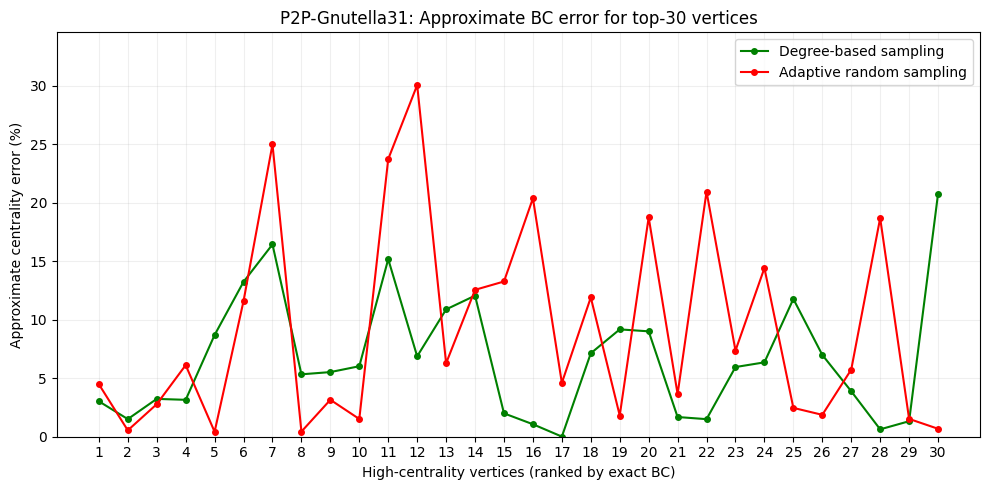

In [111]:
plot_bc_error_two_methods(
    exact_bc=exact_p2p,
    approx_bc_deg=approx_p2p_deg,
    approx_bc_rand=approx_p2p,
    top_k= top_k,
    title=f"P2P-Gnutella31: Approximate BC error for top-{top_k} vertices"
)

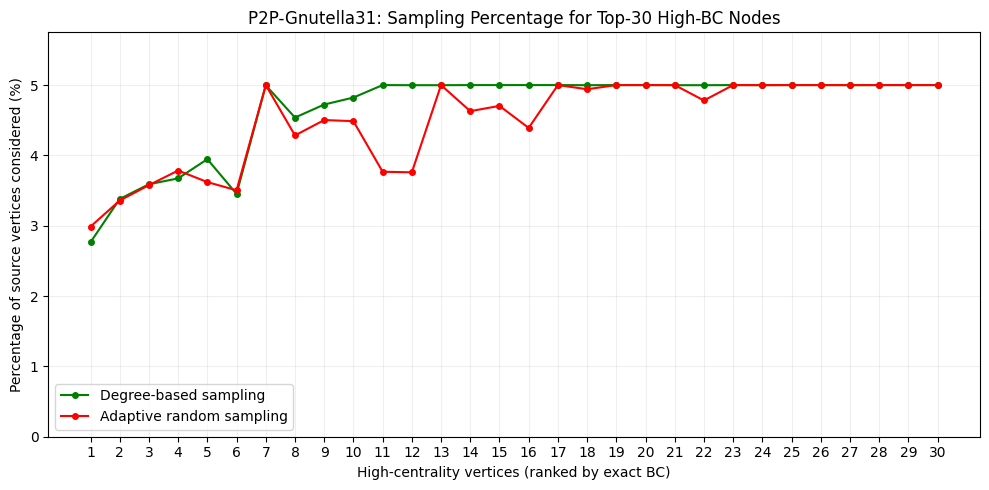

In [112]:
plot_bfs_percentages(
    G_p2p,
    exact_p2p,
    k_used_p2p_deg,
    k_used_p2p,
    top_k=top_k,
    title=f"P2P-Gnutella31: Sampling Percentage for Top-{top_k} High-BC Nodes"
)

In [113]:
avg_err_rand_p2p = compute_top_k_error(exact_p2p, approx_p2p, k=top_k)
avg_err_deg_p2p  = compute_top_k_error(exact_p2p, approx_p2p_deg, k=top_k)

print(f"Average Error (Top-{top_k} Nodes) - Random: {avg_err_rand_p2p:.2f}%")
print(f"Average Error (Top-{top_k} Nodes) - Degree-based: {avg_err_deg_p2p:.2f}%")

Average Error (Top-30 Nodes) - Random: 9.22%
Average Error (Top-30 Nodes) - Degree-based: 6.68%


## Email enron
 directed dataset https://snap.stanford.edu/data/email-Enron.html

In [55]:
enron_path = "../data/real-world-new/email-Enron_directed.txt"  
G_enron = load_graph(enron_path, directed=True, use_giant_component=True)
n_enron = G_enron.number_of_nodes()
print("Email-Enron:", n_enron, G_enron.number_of_edges())

[load] full graph from ../data/real-world-new/email-Enron_directed.txt: n=36692, m=367662
[load] use giant WCC: n=33696, m=361622
Email-Enron: 33696 361622


In [56]:
approx_enron, k_used_enron, bfs_used_enron = approx_bc_algorithm1_random(
    G_enron,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)

print(
    f"[Email-Enron approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_enron}, "
    f"avg samples per node = {np.mean(list(k_used_enron.values())):.2f}"
)

[approx] adaptive + cutoff: max 1684 BFS runs (n/20), c=5
[approx] BFS 10/1684, remaining not-done vertices: 33696
[approx] BFS 20/1684, remaining not-done vertices: 33696
[approx] BFS 30/1684, remaining not-done vertices: 33696
[approx] BFS 40/1684, remaining not-done vertices: 33696
[approx] BFS 50/1684, remaining not-done vertices: 33696
[approx] BFS 60/1684, remaining not-done vertices: 33695
[approx] BFS 70/1684, remaining not-done vertices: 33693
[approx] BFS 80/1684, remaining not-done vertices: 33693
[approx] BFS 90/1684, remaining not-done vertices: 33692
[approx] BFS 100/1684, remaining not-done vertices: 33691
[approx] BFS 110/1684, remaining not-done vertices: 33691
[approx] BFS 120/1684, remaining not-done vertices: 33690
[approx] BFS 130/1684, remaining not-done vertices: 33689
[approx] BFS 140/1684, remaining not-done vertices: 33688
[approx] BFS 150/1684, remaining not-done vertices: 33686
[approx] BFS 160/1684, remaining not-done vertices: 33686
[approx] BFS 170/1684, 

In [57]:
approx_enron_deg, k_used_enron_deg, bfs_used_enron_deg = approx_bc_algorithm1_degree_based(
    G_enron,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)

print(
    f"[Email-Enron approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_enron_deg}, "
    f"avg samples per node = {np.mean(list(k_used_enron_deg.values())):.2f}"
)

[approx-alpha-degree] max 1684 BFS runs, c=5, alpha=1.0
[approx-alpha-degree] BFS 10/1684, remaining=33695
[approx-alpha-degree] BFS 20/1684, remaining=33695
[approx-alpha-degree] BFS 30/1684, remaining=33692
[approx-alpha-degree] BFS 40/1684, remaining=33691
[approx-alpha-degree] BFS 50/1684, remaining=33691
[approx-alpha-degree] BFS 60/1684, remaining=33690
[approx-alpha-degree] BFS 70/1684, remaining=33690
[approx-alpha-degree] BFS 80/1684, remaining=33688
[approx-alpha-degree] BFS 90/1684, remaining=33686
[approx-alpha-degree] BFS 100/1684, remaining=33685
[approx-alpha-degree] BFS 110/1684, remaining=33684
[approx-alpha-degree] BFS 120/1684, remaining=33684
[approx-alpha-degree] BFS 130/1684, remaining=33683
[approx-alpha-degree] BFS 140/1684, remaining=33681
[approx-alpha-degree] BFS 150/1684, remaining=33681
[approx-alpha-degree] BFS 160/1684, remaining=33678
[approx-alpha-degree] BFS 170/1684, remaining=33677
[approx-alpha-degree] BFS 180/1684, remaining=33676
[approx-alpha-deg

In [69]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_enron = nx.betweenness_centrality(G_enron, normalized=False)
t1 = perf_counter()
print(f"[Email-Enron exact] finished in {t1 - t0:.2f}s")

[Email-Enron exact] finished in 2903.77s


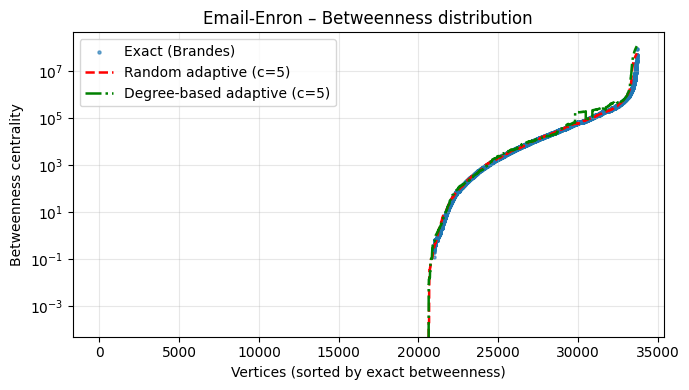

In [70]:
plot_fig1(
    exact_bc      = exact_enron,
    approx_bc_rand= approx_enron,        # random adaptive result
    approx_bc_deg = approx_enron_deg,    # degree-based adaptive result
    title_suffix  = "Email-Enron"
)

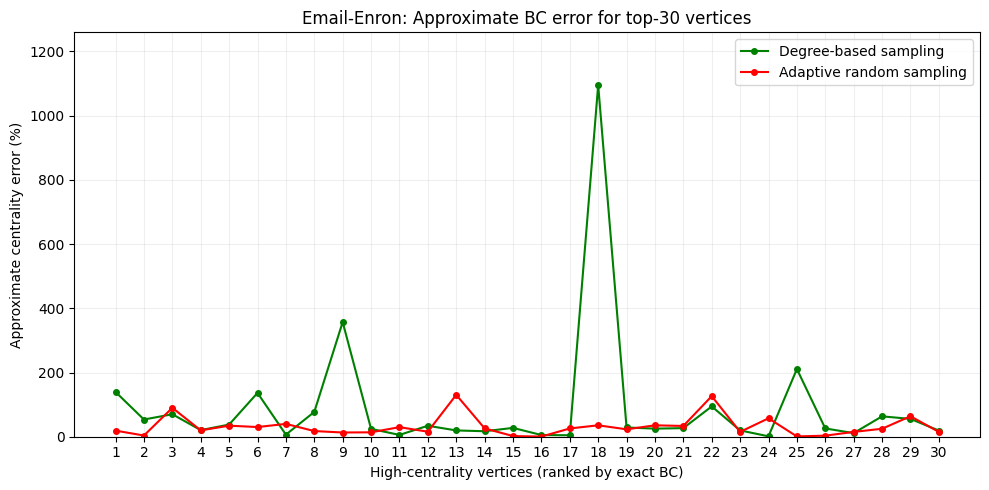

In [114]:
plot_bc_error_two_methods(
    exact_bc=exact_enron,
    approx_bc_deg=approx_enron_deg,
    approx_bc_rand=approx_enron,
    top_k=top_k,
    title=f"Email-Enron: Approximate BC error for top-{top_k} vertices"
)

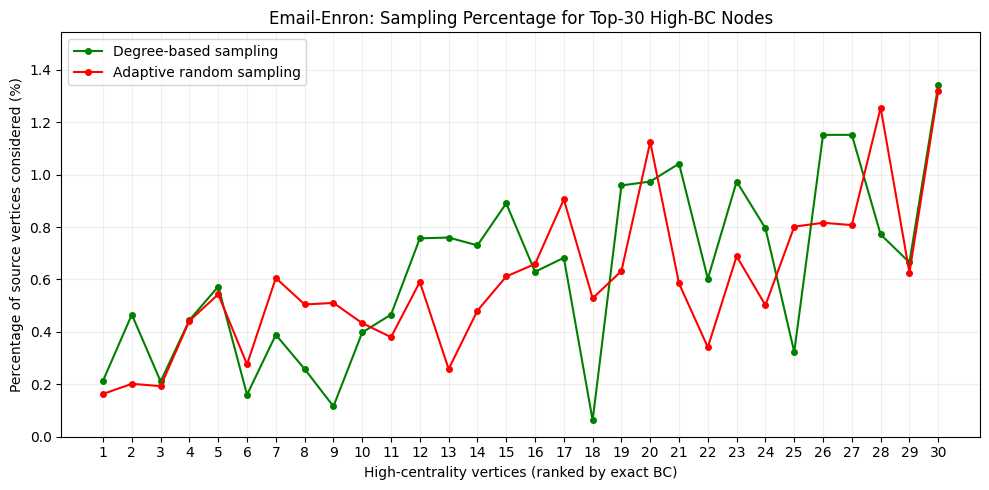

In [115]:
plot_bfs_percentages(
    G_enron,
    exact_enron,
    k_used_enron_deg,
    k_used_enron,
    top_k=top_k,
    title=f"Email-Enron: Sampling Percentage for Top-{top_k} High-BC Nodes"
)

In [116]:
avg_err_rand_enron = compute_top_k_error(exact_enron, approx_enron, k=top_k)
avg_err_deg_enron  = compute_top_k_error(exact_enron, approx_enron_deg, k=top_k)


print(f"Average Error (Top-{top_k} Nodes) - Random: {avg_err_rand_enron:.2f}%")
print(f"Average Error (Top-{top_k} Nodes) - Degree-based: {avg_err_deg_enron:.2f}%")

Average Error (Top-30 Nodes) - Random: 32.02%
Average Error (Top-30 Nodes) - Degree-based: 90.46%


## Facebook Large Page-Page Network

undirected
https://snap.stanford.edu/data/facebook-large-page-page-network.html

In [98]:
path = "../data/real-world-new/musae_facebook_edges.csv"
G_fb = load_csv_edge_list(path, directed=False)

print(G_fb.number_of_nodes(), G_fb.number_of_edges())

Facebook CSV graph: n=22470, m=171002
22470 171002


In [99]:
approx_fb, k_used_fb, bfs_used_fb = approx_bc_algorithm1_random(
    G_fb,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)

print(
    f"[Facebook approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_fb}, "
    f"avg samples per node = {np.mean(list(k_used_fb.values())):.2f}"
)

[approx] adaptive + cutoff: max 1123 BFS runs (n/20), c=5
[approx] BFS 10/1123, remaining not-done vertices: 22470
[approx] BFS 20/1123, remaining not-done vertices: 22470
[approx] BFS 30/1123, remaining not-done vertices: 22470
[approx] BFS 40/1123, remaining not-done vertices: 22470
[approx] BFS 50/1123, remaining not-done vertices: 22470
[approx] BFS 60/1123, remaining not-done vertices: 22469
[approx] BFS 70/1123, remaining not-done vertices: 22468
[approx] BFS 80/1123, remaining not-done vertices: 22468
[approx] BFS 90/1123, remaining not-done vertices: 22468
[approx] BFS 100/1123, remaining not-done vertices: 22468
[approx] BFS 110/1123, remaining not-done vertices: 22468
[approx] BFS 120/1123, remaining not-done vertices: 22466
[approx] BFS 130/1123, remaining not-done vertices: 22466
[approx] BFS 140/1123, remaining not-done vertices: 22466
[approx] BFS 150/1123, remaining not-done vertices: 22466
[approx] BFS 160/1123, remaining not-done vertices: 22465
[approx] BFS 170/1123, 

In [100]:
approx_fb_deg, k_used_fb_deg, bfs_used_fb_deg = approx_bc_algorithm1_degree_based(
    G_fb,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)

print(
    f"[Facebook approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_fb_deg}, "
    f"avg samples per node = {np.mean(list(k_used_fb_deg.values())):.2f}"
)

[approx-alpha-degree] max 1123 BFS runs, c=5, alpha=1.0
[approx-alpha-degree] BFS 10/1123, remaining=22470
[approx-alpha-degree] BFS 20/1123, remaining=22470
[approx-alpha-degree] BFS 30/1123, remaining=22470
[approx-alpha-degree] BFS 40/1123, remaining=22467
[approx-alpha-degree] BFS 50/1123, remaining=22467
[approx-alpha-degree] BFS 60/1123, remaining=22466
[approx-alpha-degree] BFS 70/1123, remaining=22462
[approx-alpha-degree] BFS 80/1123, remaining=22462
[approx-alpha-degree] BFS 90/1123, remaining=22460
[approx-alpha-degree] BFS 100/1123, remaining=22459
[approx-alpha-degree] BFS 110/1123, remaining=22458
[approx-alpha-degree] BFS 120/1123, remaining=22458
[approx-alpha-degree] BFS 130/1123, remaining=22458
[approx-alpha-degree] BFS 140/1123, remaining=22456
[approx-alpha-degree] BFS 150/1123, remaining=22453
[approx-alpha-degree] BFS 160/1123, remaining=22451
[approx-alpha-degree] BFS 170/1123, remaining=22451
[approx-alpha-degree] BFS 180/1123, remaining=22451
[approx-alpha-deg

In [101]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_fb = nx.betweenness_centrality(G_fb, normalized=False)
t1 = perf_counter()
print(f"[Facebook Large Page-Page Network exact] finished in {t1 - t0:.2f}s")

[Facebook Large Page-Page Network exact] finished in 1835.69s


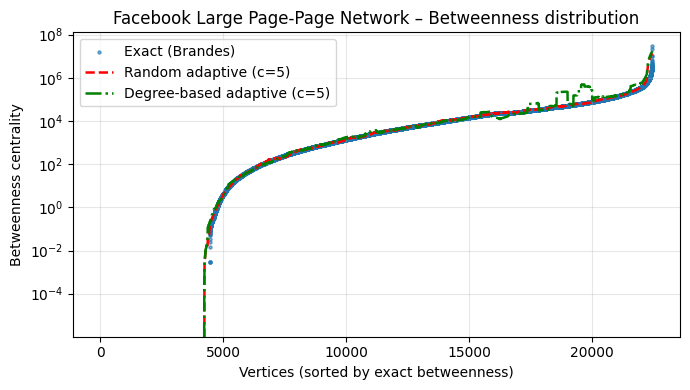

In [102]:
plot_fig1(
    exact_bc     = exact_fb,
    approx_bc_rand= approx_fb,        # random adaptive result
    approx_bc_deg = approx_fb_deg,    # degree-based adaptive result
    title_suffix  = "Facebook Large Page-Page Network"
)

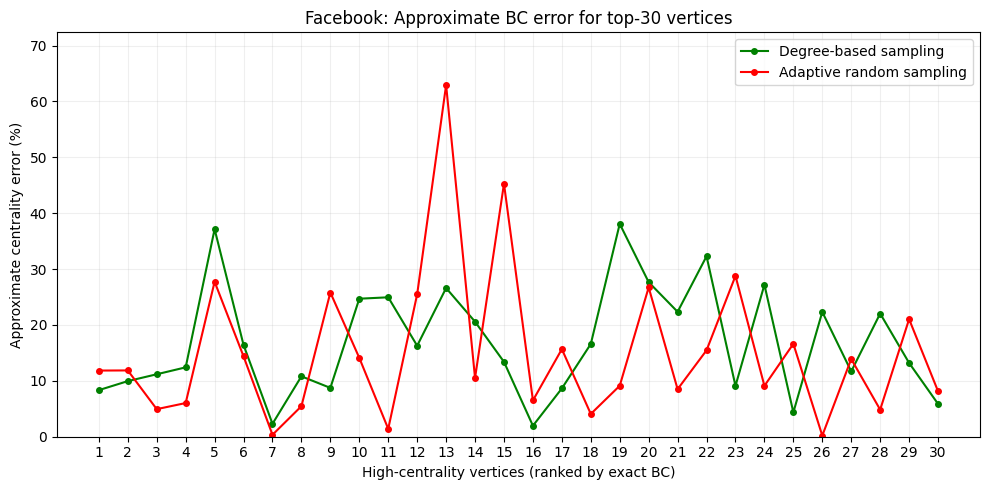

In [117]:
plot_bc_error_two_methods(
    exact_bc=exact_fb,
    approx_bc_deg=approx_fb_deg,
    approx_bc_rand=approx_fb,
    top_k= top_k,
    title=f"Facebook: Approximate BC error for top-{top_k} vertices"
)

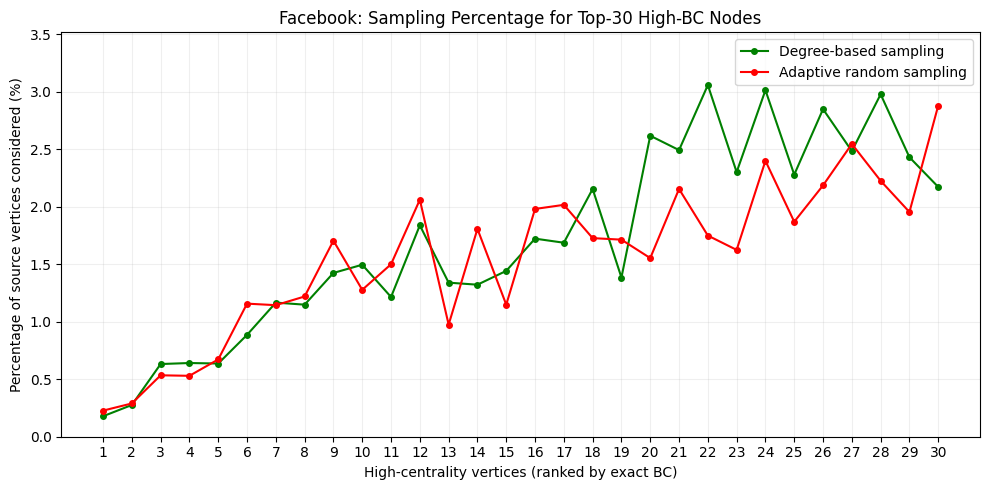

In [118]:
plot_bfs_percentages(
    G_fb,
    exact_fb,
    k_used_fb_deg,
    k_used_fb,
    top_k= top_k,
    title=f"Facebook: Sampling Percentage for Top-{top_k} High-BC Nodes"
)

In [125]:
avg_err_rand_fb = compute_top_k_error(exact_fb, approx_fb, k=top_k)
avg_err_deg_fb  = compute_top_k_error(exact_fb, approx_fb_deg, k=top_k)

print(f"Average Error (Top-{top_k} Nodes) - Random: {avg_err_rand_fb:.2f}%")
print(f"Average Error (Top-{top_k} Nodes) - Degree-based: {avg_err_deg_fb:.2f}%")


Average Error (Top-30 Nodes) - Random: 15.23%
Average Error (Top-30 Nodes) - Degree-based: 16.91%


## Twitter

directed https://snap.stanford.edu/data/ego-Twitter.html

In [126]:
path = "../data/real-world-new/twitter_combined.txt"
G_twitter= load_graph(path, directed=True)
print(G_twitter.number_of_nodes(), G_twitter.number_of_edges())

[load] full graph from ../data/real-world-new/twitter_combined.txt: n=81306, m=1768149
81306 1768149


In [ ]:
approx_twitter, k_used_twitter, bfs_used_twitter = approx_bc_algorithm1_random(
    G_twitter,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=42,
)

print(
    f"[Twitter approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_twitter}, "
    f"avg samples per node = {np.mean(list(k_used_twitter.values())):.2f}"
)

[approx] adaptive + cutoff: max 4065 BFS runs (n/20), c=5.0
[approx] BFS 10/4065, remaining not-done vertices: 81306
[approx] BFS 20/4065, remaining not-done vertices: 81306
[approx] BFS 30/4065, remaining not-done vertices: 81306
[approx] BFS 40/4065, remaining not-done vertices: 81305
[approx] BFS 50/4065, remaining not-done vertices: 81305
[approx] BFS 60/4065, remaining not-done vertices: 81305
[approx] BFS 70/4065, remaining not-done vertices: 81304
[approx] BFS 80/4065, remaining not-done vertices: 81304
[approx] BFS 90/4065, remaining not-done vertices: 81303
[approx] BFS 100/4065, remaining not-done vertices: 81303
[approx] BFS 110/4065, remaining not-done vertices: 81303
[approx] BFS 120/4065, remaining not-done vertices: 81303
[approx] BFS 130/4065, remaining not-done vertices: 81302
[approx] BFS 140/4065, remaining not-done vertices: 81302
[approx] BFS 150/4065, remaining not-done vertices: 81302
[approx] BFS 160/4065, remaining not-done vertices: 81302
[approx] BFS 170/4065

In [ ]:
approx_twitter_deg, k_used_twitter_deg, bfs_used_twitter_deg = approx_bc_algorithm1_degree_based(
    G_twitter,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
)

print(
    f"[Twitter approx] c={c_val}, cutoff=n/{cutoff_factor}, "
    f"BFS used = {bfs_used_twitter_deg}, "
    f"avg samples per node = {np.mean(list(k_used_twitter_deg.values())):.2f}"
)

[approx-alpha-degree] max 4065 BFS runs, c=5.0, alpha=1.0
[approx-alpha-degree] BFS 10/4065, remaining=81306
[approx-alpha-degree] BFS 20/4065, remaining=81306
[approx-alpha-degree] BFS 30/4065, remaining=81306
[approx-alpha-degree] BFS 40/4065, remaining=81305
[approx-alpha-degree] BFS 50/4065, remaining=81305
[approx-alpha-degree] BFS 60/4065, remaining=81304
[approx-alpha-degree] BFS 70/4065, remaining=81304
[approx-alpha-degree] BFS 80/4065, remaining=81304
[approx-alpha-degree] BFS 90/4065, remaining=81302
[approx-alpha-degree] BFS 100/4065, remaining=81302
[approx-alpha-degree] BFS 110/4065, remaining=81302
[approx-alpha-degree] BFS 120/4065, remaining=81302
[approx-alpha-degree] BFS 130/4065, remaining=81302
[approx-alpha-degree] BFS 140/4065, remaining=81302
[approx-alpha-degree] BFS 150/4065, remaining=81301
[approx-alpha-degree] BFS 160/4065, remaining=81301
[approx-alpha-degree] BFS 170/4065, remaining=81301
[approx-alpha-degree] BFS 180/4065, remaining=81298
[approx-alpha-d

In [27]:
# Exact Brandes O(nm) 
t0 = perf_counter()
exact_twitter = nx.betweenness_centrality(G_twitter, normalized=False)
t1 = perf_counter()
print(f"[Twitter exact] finished in {t1 - t0:.2f}s")

[Twitter exact] finished in 29470.98s


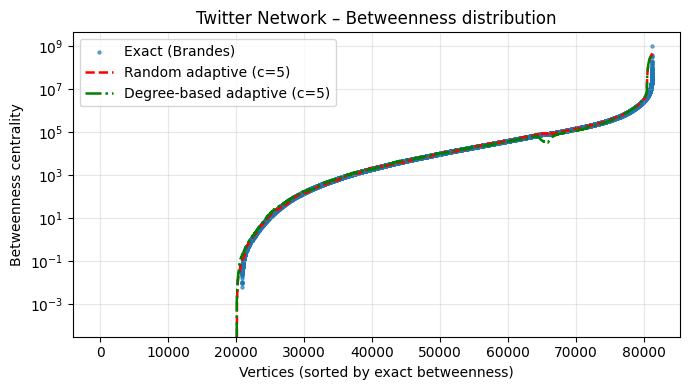

In [28]:
plot_fig1(
    exact_bc     = exact_twitter,
    approx_bc_rand= approx_twitter,        # random adaptive result
    approx_bc_deg = approx_twitter_deg,    # degree-based adaptive result
    title_suffix  = "Twitter Network"
)

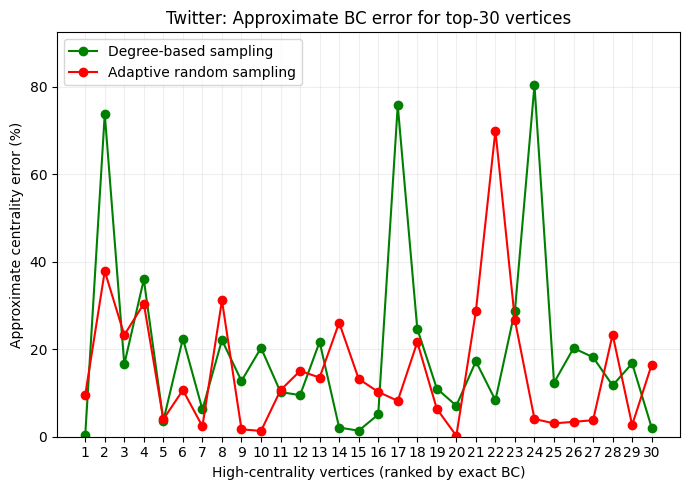

In [ ]:
plot_bc_error_two_methods(
    exact_bc=exact_twitter,
    approx_bc_deg=approx_twitter_deg,
    approx_bc_rand=approx_twitter,
    top_k=top_k,
    title=f"Twitter: Approximate BC error for top-{top_k} vertices"
)

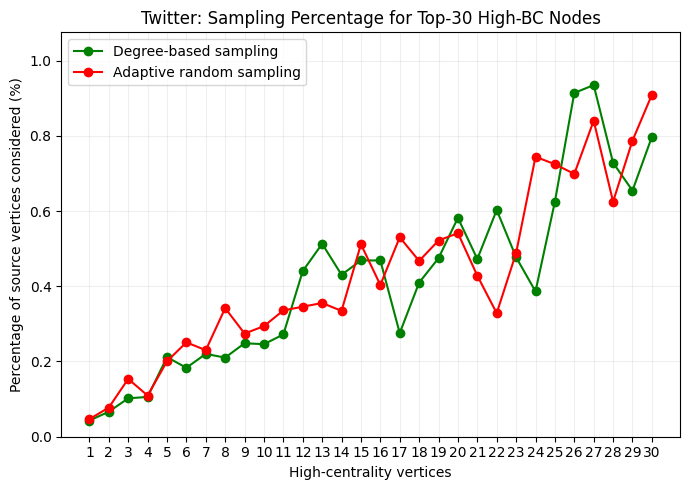

In [ ]:
plot_bfs_percentages(
    G_twitter,
    exact_twitter,
    k_used_twitter_deg,
    k_used_twitter,
    top_k=top_k,
    title=f"Twitter: Sampling Percentage for Top-{top_k} High-BC Nodes"
)

In [ ]:
avg_err_rand_twitter = compute_top_k_error(exact_twitter, approx_twitter, top_k=top_k)
avg_err_deg_twitter  = compute_top_k_error(exact_twitter, approx_twitter_deg, top_k=top_k)

print(f"Average Error (Top-{top_k} Nodes) - Random: {avg_err_rand_twitter:.2f}%")
print(f"Average Error (Top-{top_k} Nodes) - Degree-based: {avg_err_deg_twitter:.2f}%")

Average error (adaptive random): 0.8688379339876742
Average error (degree-based adaptive): 0.823879040095754


## Weighted algorithm (Based on Dijkstra's algorithm)

In [85]:
import heapq

def brandes_single_source_dependencies_weighted(G, s, weight='weight'):
    """
    Fixed Dijkstra-based Brandes using epsilon for float comparison.
    """
    # 1. Initialization
    S = [] 
    P = {v: [] for v in G}
    
    # standard Dijkstra structures
    sigma = dict.fromkeys(G, 0.0)
    dist = dict.fromkeys(G, float('inf'))
    
    sigma[s] = 1.0
    dist[s] = 0
    
    Q = [(0, s)]
    
    # Epsilon for floating-point comparison
    EPSILON = 1e-9 
    
    while Q:
        d, v = heapq.heappop(Q)
        
        # Stale entry check (Dijkstra lazy deletion)
        # If the popped distance d is greater than the known shortest distance dist[v] (beyond epsilon), skip
        if d > dist[v] + EPSILON:
            continue
            
        S.append(v)
        
        for w in G[v]:
            edge_wt = G[v][w].get(weight, 1.0)
            new_dist = dist[v] + edge_wt
            
            # Case 1: Found a strictly shorter path
            # (dist[w] > new_dist) becomes:
            if dist[w] > new_dist + EPSILON:
                dist[w] = new_dist
                sigma[w] = sigma[v]
                P[w] = [v]
                heapq.heappush(Q, (dist[w], w))
                
            # Case 2: Found an equal length path (within epsilon)
            # (dist[w] == new_dist) becomes:
            elif abs(dist[w] - new_dist) < EPSILON:
                sigma[w] += sigma[v]
                P[w].append(v)
                
    # 2. Dependency accumulation (Back-propagation)
    delta = dict.fromkeys(G, 0.0)
    while S:
        w = S.pop()
        for v in P[w]:
            if sigma[w] != 0:
                # Brandes recursion
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])
                
    return delta

In [87]:
def approx_bc_algorithm1_random_weighted(G, c=5.0, cutoff_factor=20, seed=0, weight='weight'):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    max_sssp = max(1, n // cutoff_factor)
    print(f"[approx-weighted] adaptive + cutoff: max {max_sssp} SSSP runs, c={c}")

    S = {v: 0.0 for v in nodes}
    k = {v: 0   for v in nodes}
    done = {v: False for v in nodes}
    remaining = n

    sssp_used = 0
    t0 = perf_counter()

    while sssp_used < max_sssp and remaining > 0:
        s = rng.choice(nodes)
        
        delta = brandes_single_source_dependencies_weighted(G, s, weight=weight)
        sssp_used += 1

        for v in nodes:
            if done[v] or v == s:
                continue
            S[v] += delta[v]
            k[v] += 1
            if S[v] >= c * n:
                done[v] = True
                remaining -= 1

        if sssp_used % 10 == 0 or sssp_used == max_sssp:
            print(f"[approx-weighted] SSSP {sssp_used}/{max_sssp}, remaining: {remaining}")

    t1 = perf_counter()
    print(f"[approx-weighted] finished in {t1 - t0:.2f}s, SSSP_used={sssp_used}")
    bc_hat = {
        v: (n * S[v] / k[v]) if k[v] > 0 else 0.0
        for v in nodes
    }
    
    # Correction for undirected graphs
    if not G.is_directed():
        for v in bc_hat:
            bc_hat[v] /= 2.0

    return bc_hat, k, sssp_used

def approx_bc_algorithm1_degree_based_weighted(G, c=5.0, cutoff_factor=20, alpha=1.0, seed=0, weight='weight'):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    degs = np.array([G.degree(v) for v in nodes], dtype=float)
    if alpha == 0:
        weights = np.ones(n, dtype=float)
    else:
        weights = np.power(degs, alpha)
    
    if np.all(weights == 0):
        probs = np.ones(n, dtype=float) / n
    else:
        probs = weights / weights.sum()

    cum_probs = np.cumsum(probs)
    
    def sample_source_and_prob():
        x = rng.random()
        idx = np.searchsorted(cum_probs, x, side="left")
        if idx >= n: idx = n - 1
        return nodes[idx], probs[idx]

    max_sssp = max(1, n // cutoff_factor)
    print(f"[approx-weighted-degree] max {max_sssp} SSSP runs, c={c}, alpha={alpha}")

    # compute final BC estimates using S_weighted
    S_weighted = {v: 0.0 for v in nodes}  
    S_raw      = {v: 0.0 for v in nodes}  
    
    k = {v: 0   for v in nodes}
    done = {v: False for v in nodes}
    remaining = n
    sssp_used = 0
    t0 = perf_counter()

    while sssp_used < max_sssp and remaining > 0:
        s, p_s = sample_source_and_prob()
        
        delta = brandes_single_source_dependencies_weighted(G, s, weight=weight)
        sssp_used += 1
        
        # Bias Correction factor
        scale_factor = 1.0 / (n * p_s) if p_s > 0 else 0

        for v in nodes:
            if done[v] or v == s:
                continue
            
            # update both sums
            S_weighted[v] += delta[v] * scale_factor  
            S_raw[v]      += delta[v]                 
            
            k[v] += 1
            
            # stop condition based on S_raw
            if S_raw[v] >= c * n: 
                done[v] = True
                remaining -= 1

        if sssp_used % 10 == 0 or sssp_used == max_sssp:
             pass

    t1 = perf_counter()
    print(f"[approx-weighted-degree] finished in {t1 - t0:.2f}s, used {sssp_used} samples")

    # compute final BC estimates using S_weighted
    bc_hat = {
        v: (n * S_weighted[v] / k[v]) if k[v] > 0 else 0.0
        for v in nodes
    }

    if not G.is_directed():
        for v in bc_hat:
            bc_hat[v] /= 2.0

    return bc_hat, k, sssp_used

## Bio-HS-CX
weighted, undirected 
https://networkrepository.com/bio-HS-CX.php

In [88]:
# 1. Load Weighted Graph
bio_path = "../data/real-world-new/bio-HS-CX_weighted_undirected.edges"

G_bio = nx.read_edgelist(
    bio_path, 
    nodetype=int, 
    data=(('weight', float),), 
    create_using=nx.Graph() # Undirected
)

# get the giant component
if not nx.is_connected(G_bio):
    gcc_nodes = max(nx.connected_components(G_bio), key=len)
    G_bio = G_bio.subgraph(gcc_nodes).copy()

n_bio = G_bio.number_of_nodes()
print(f"Bio-HS-CX: n={n_bio}, m={G_bio.number_of_edges()}")

Bio-HS-CX: n=4409, m=108816


In [91]:
# Run Weighted Random Approx
approx_bio, k_used_bio, sssp_used_bio = approx_bc_algorithm1_random_weighted(
    G_bio,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
    weight='weight'
)

print(f"[Bio Weighted Random] SSSP used = {sssp_used_bio}, "
      f"avg samples = {np.mean(list(k_used_bio.values())):.2f}")

[approx-weighted] adaptive + cutoff: max 220 SSSP runs, c=5
[approx-weighted] SSSP 10/220, remaining: 4409
[approx-weighted] SSSP 20/220, remaining: 4409
[approx-weighted] SSSP 30/220, remaining: 4409
[approx-weighted] SSSP 40/220, remaining: 4409
[approx-weighted] SSSP 50/220, remaining: 4409
[approx-weighted] SSSP 60/220, remaining: 4409
[approx-weighted] SSSP 70/220, remaining: 4409
[approx-weighted] SSSP 80/220, remaining: 4409
[approx-weighted] SSSP 90/220, remaining: 4409
[approx-weighted] SSSP 100/220, remaining: 4409
[approx-weighted] SSSP 110/220, remaining: 4409
[approx-weighted] SSSP 120/220, remaining: 4409
[approx-weighted] SSSP 130/220, remaining: 4409
[approx-weighted] SSSP 140/220, remaining: 4409
[approx-weighted] SSSP 150/220, remaining: 4409
[approx-weighted] SSSP 160/220, remaining: 4409
[approx-weighted] SSSP 170/220, remaining: 4409
[approx-weighted] SSSP 180/220, remaining: 4409
[approx-weighted] SSSP 190/220, remaining: 4409
[approx-weighted] SSSP 200/220, remai

In [92]:
# Run Weighted Degree-based Approx
approx_bio_deg, k_used_bio_deg, sssp_used_bio_deg = approx_bc_algorithm1_degree_based_weighted(
    G_bio,
    c=c_val,
    cutoff_factor=cutoff_factor,
    seed=seed,
    weight='weight'
)

print(f"[Bio Weighted Degree] SSSP used = {sssp_used_bio_deg}, "
      f"avg samples = {np.mean(list(k_used_bio_deg.values())):.2f}")

[approx-weighted-degree] max 220 SSSP runs, c=5, alpha=1.0
[approx-weighted-degree] finished in 26.06s, used 220 samples
[Bio Weighted Degree] SSSP used = 220, avg samples = 219.95


In [93]:
#Exact Weighted Brandes 
print("Running Exact Weighted BC (NetworkX).")
t0 = perf_counter()
exact_bio = nx.betweenness_centrality(G_bio, normalized=False, weight='weight')
t1 = perf_counter()
print(f"[Bio Exact] finished in {t1 - t0:.2f}s")

Running Exact Weighted BC (NetworkX).
[Bio Exact] finished in 397.46s


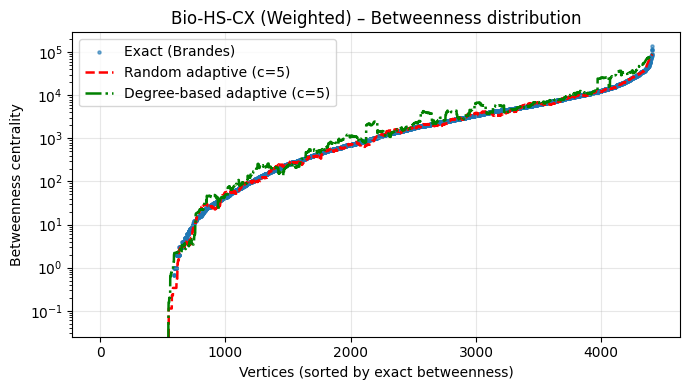

In [94]:
plot_fig1(
    exact_bc=exact_bio,
    approx_bc_rand=approx_bio,
    approx_bc_deg=approx_bio_deg,
    title_suffix="Bio-HS-CX (Weighted)"
)

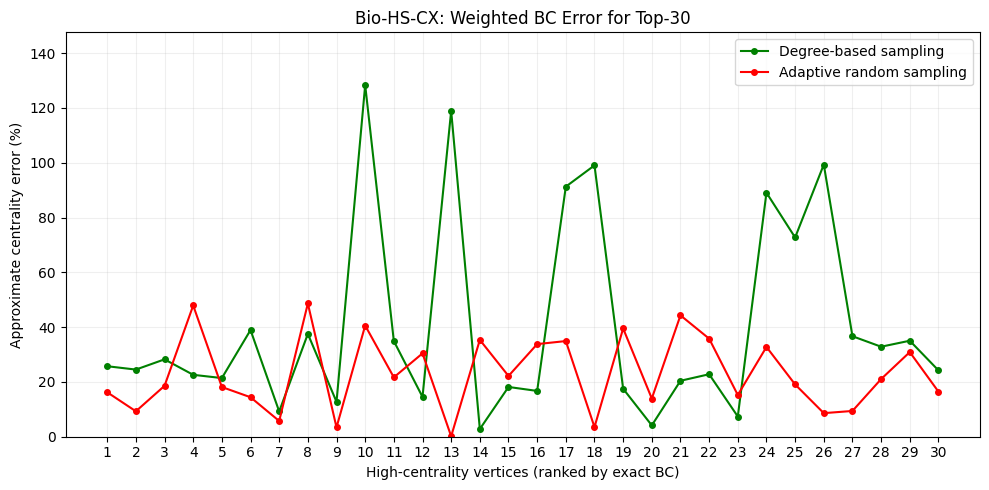

In [120]:
plot_bc_error_two_methods(
    exact_bc=exact_bio,
    approx_bc_deg=approx_bio_deg,
    approx_bc_rand=approx_bio,
    top_k=top_k,
    title=f"Bio-HS-CX: Weighted BC Error for Top-{top_k}"
)

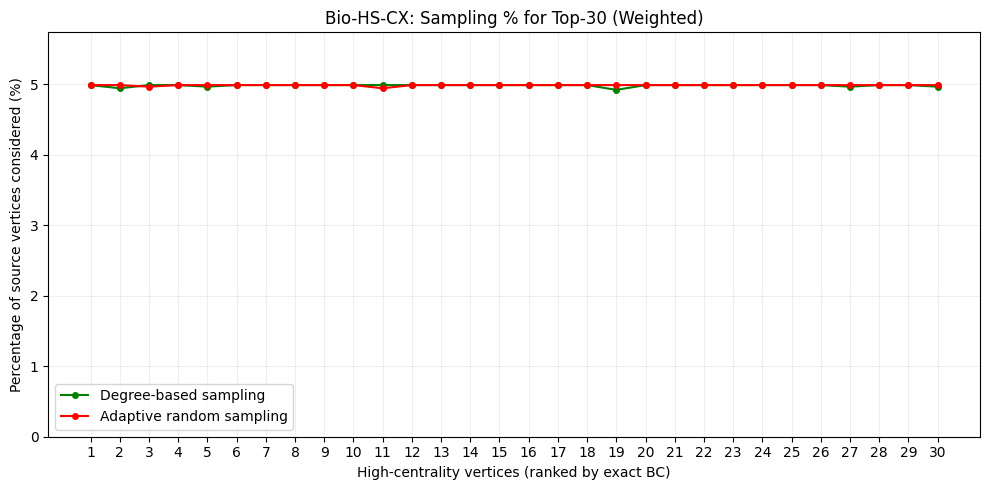

In [121]:
plot_bfs_percentages(
    G_bio,
    exact_bio,
    k_used_bio_deg,
    k_used_bio,
    top_k=top_k,
    title=f"Bio-HS-CX: Sampling % for Top-{top_k} (Weighted)"
)

In [123]:
# Calculate Average Error
avg_err_rand_bio = compute_top_k_error(exact_bio, approx_bio, k=top_k)
avg_err_deg_bio  = compute_top_k_error(exact_bio, approx_bio_deg, k=top_k)

print(f"Bio Average Error (Top-{top_k}) - Random: {avg_err_rand_bio:.2f}%")
print(f"Bio Average Error (Top-{top_k}) - Degree: {avg_err_deg_bio:.2f}%")

Bio Average Error (Top-30) - Random: 23.06%
Bio Average Error (Top-30) - Degree: 40.26%
